### Reader

In [5]:
import os
import xml.etree.ElementTree as ET
cache_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache'
filenames = [filename for filename in os.listdir(cache_path) if filename.endswith('tei.xml')]


def get_full_text(element):
    text = element.text or ''
    for subelement in element:
        text += ET.tostring(subelement, encoding='unicode', method='text')
        if subelement.tail:
            text += subelement.tail
    return text.strip()

iter_filenames = (iter(filenames))

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache'

In [ ]:
file_path = os.path.join(cache_path, next(iter_filenames)) 
file_path

In [ ]:
file_dict = {}
tree = ET.parse(file_path)
root = tree.getroot()

namespace = {'tei': 'http://www.tei-c.org/ns/1.0'}

In [ ]:
# title
title = root.find('.//tei:teiHeader/tei:fileDesc/tei:titleStmt/tei:title', namespaces=namespace)
file_dict['title'] = title.text
file_dict

In [ ]:
# authors
authors = root.findall('.//tei:teiHeader/tei:fileDesc/tei:sourceDesc/tei:biblStruct/tei:analytic/tei:author/tei:persName', namespaces=namespace)
file_dict['authors'] = []
for author in authors:
    forename = author.findall('tei:forename', namespaces=namespace)
    if len(forename) == 0:
        continue
    forename = ' '.join(name.text for name in forename)
    surname = ' '.join([name.text for name in author.findall('tei:surname', namespaces=namespace)])
    author_name = forename + ' ' + surname
    file_dict['authors'].append(author_name)
file_dict

In [ ]:
# abstract
abstract = root.find('.//tei:teiHeader/tei:profileDesc/tei:abstract/tei:div/tei:p', namespaces=namespace)
print(abstract)
if abstract is not None:
    file_dict['abstract'] = abstract.text
file_dict

In [ ]:
# Body
body = root.findall('.//tei:text/tei:body/tei:div', namespaces=namespace)

for i, child in enumerate(body):
    ps = child.findall('.//tei:p', namespaces=namespace)
    if len(ps) == 0:
        continue
    head = child.find('.//tei:head', namespaces=namespace).text
    content = '\n'.join([get_full_text(p) for p in ps])
    file_dict[head] = content
file_dict

In [ ]:
from utils.custom_document_reader import CustomDocumentReader

documents = CustomDocumentReader(
    input_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/data",
    cache_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache",
    config_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/utils/config.json",
    remove_cache=False
)._load_data()

### CustomSplitter

In [ ]:
from llama_index.core.node_parser import SentenceSplitter

ss1 = SentenceSplitter(
    chunk_size=1024,
    include_metadata=True,
    include_prev_next_rel=True,
)

In [ ]:
from llama_index.core.storage.docstore import SimpleDocumentStore
nodes = ss1.get_nodes_from_documents(documents)
docstore = SimpleDocumentStore()
docstore.add_documents(nodes)
docstore.persist(persist_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/test.json")


In [ ]:
from llama_index.core.node_parser import SimpleFileNodeParser

nodes = SimpleFileNodeParser().get_nodes_from_documents(documents=documents)

In [ ]:
for k, v in nodes[0].to_dict().items():
    print(f"key: {k}\nvalue: {v}\n\n")

In [ ]:
from utils.custom_document_reader import CustomDocumentReader

documents = CustomDocumentReader(
    input_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/data",
    cache_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache",
    config_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/utils/config.json",
    remove_cache=False
)._load_data()

from utils.custom_parser import CustomHierarchicalNodeParser
hnp = CustomHierarchicalNodeParser.from_defaults()
hnp._parse_nodes(documents)

### Test custom document reader

In [ ]:
from utils.custom_document_reader import CustomDocumentReader

documents = CustomDocumentReader(
    input_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/data",
    cache_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache",
    config_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/utils/config.json",
    remove_cache=False
)._load_data()

from utils.custom_parser import CustomHierarchicalNodeParser
hnp = CustomHierarchicalNodeParser.from_defaults()
nodes = hnp.get_nodes_from_documents(documents)

In [ ]:
len(documents)

In [ ]:
len(nodes)

In [ ]:
from utils.custom_extractor import HuggingfaceBasedExtractor, OllamaBasedExtractor, OpenAIBasedExtractor

extractor = OllamaBasedExtractor(
    model_name='sammcj/sfr-embedding-mistral:Q4_K_M',
    only_meta={'level': ['section']}
)

extractor.extract(nodes)

### Pydantic

In [ ]:
from utils.get import get_a_store
file_path = 'D:\\Projects(D)\\Fine-Tuned-GPT-2-with-articles-ground-truth\\code\\llamaIndex\\.cache\\test-gpt-4o-batch_1_parser_CustomHierarchicalNodeParser-vicuna_13b.json'
docstore = get_a_store('SimpleDocumentStore').from_persist_path(persist_path=file_path)
nodes = [node for _, node in docstore.docs.items()][:4]

In [ ]:
from custom.custom_extractor import OpenAIBasedQARExtractor
from custom.schema import QAR
from dotenv import load_dotenv

load_dotenv()
extractor = OpenAIBasedQARExtractor(
    model_name='gpt-4o',
    cache_dir='D:\\Projects(D)\\Fine-Tuned-GPT-2-with-articles-ground-truth\\code\\llamaIndex\\.cache',
    mode='immediately',
    embedding_only=True,
    only_meta=None
)

In [ ]:
outputs = extractor.extract(nodes, 'test', 'test_action', 'D:\\Projects(D)\\Fine-Tuned-GPT-2-with-articles-ground-truth\\code\\llamaIndex\\.cache')

In [ ]:
nodes[0].metadata['questions_this_excerpt_can_answer_and_corresponding_answers_and_reasons'].split('\n')

In [ ]:
nodes[0].metadata['questions_this_excerpt_can_answer_and_corresponding_answers_and_reasons'].split('\n')

In [ ]:
import re
def extract_json_str(text: str) -> list:
    """Extract JSON strings from text."""
    matches = re.findall(r'\{.*?\}', text.strip(), re.MULTILINE | re.IGNORECASE | re.DOTALL)
    if not matches:
        raise ValueError(f"Could not extract json strings from output: {text}")
    return matches

text = """```json
[
    {
        "Question": "What are the main pathological features of Parkinson's disease as described in the document?",
        "Answer": "The main pathological feature of Parkinson's disease is the progressive destruction of dopamine-producing cells in the substantia nigra region of the brain stem.",
        "Reason": "This specific detail about the pathological feature is highlighted in the context and is not general knowledge."
    },
    {
        "Question": "How does the document describe the role of neuromelanin in Parkinson's disease?",
        "Answer": "The document suggests that neuromelanin may serve as an indication of catecholamine synthesis in neuronal systems containing dopamine or norepinephrine and may influence neuronal metabolism due to the heavy metals it contains.",
        "Reason": "This insight into neuromelanin's role and its potential impact on neuronal metabolism is unique to the context provided."
    },
    {
        "Question": "What evidence does the document provide to support the hypothesis that oxidative stress is involved in Parkinson's disease?",
        "Answer": "The document provides evidence such as increased membrane peroxidation in the substantia nigra, elevated TBA-reactive substance levels, increased 8-hydroxy-2′deoxyguanosine levels, and low phospholipid turnover in the substantia nigra.",
        "Reason": "These specific pieces of evidence are detailed in the context and are not commonly known facts."
    },
    {
        "Question": "What are the potential sources of increased oxidative stress in Parkinson's disease according to the document?",
        "Answer": "Potential sources include dopamine metabolism, mitochondrial dysfunction, increased free iron levels, accumulation of AGEs, reduced activity of free radical defense systems, and the deleterious role of glial cells.",
        "Reason": "The document lists these specific sources, providing a comprehensive view that is unique to the context."
    },
    {
        "Question": "How does the document describe the involvement of mitochondrial dysfunction in Parkinson's disease?",
        "Answer": "The document describes mitochondrial dysfunction as involving abnormalities of the respiratory chain, particularly a 30-40% decrease in complex I activity in the substantia nigra, which leads to reductions in ATP production and elevated ROS generation.",
        "Reason": "This detailed description of mitochondrial dysfunction and its specific impact on Parkinson's disease is unique to the context provided."
    }
]
"""

for k in extract_json_str(text):
    print(k)
# print(extract_json_str(text))

### Custom IO nodes

In [ ]:
from llama_index.core.storage.docstore import SimpleDocumentStore
docstore = SimpleDocumentStore.from_persist_path(persist_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/test_2_parser_CustomHierarchicalNodeParser-ollama_vicuna_13b.json")
nodes = [node for _, node in docstore.docs.items()]

In [ ]:
from llama_index.core.schema import TextNode
TextNode.from_dict(nodes[0].to_dict())

In [ ]:
len(nodes)

In [ ]:
nodes[0].get_content()

In [ ]:
import os, sys
root_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
sys.path.insert(0, root_dir)

In [ ]:
import os
import json
from typing import List
from tqdm import tqdm
from llama_index.core.schema import BaseNode, TextNode

def save_nodes_jsonl(file_path: str, nodes: List[BaseNode]):
    try:
        with open(file_path, 'w') as file:
            for node in tqdm(nodes, desc='Saving nodes...'):
                json.dump(node.to_dict(), file)
                file.write('\n')
    except Exception as e:
        print(f"An error occurred while saving nodes: {e}")

def load_nodes_jsonl(file_path: str) -> List[TextNode]:
    nodes = []
    
    try:
        # Get the total file size
        file_size = os.path.getsize(file_path)
        
        # Read the file and track progress based on bytes read
        with open(file_path, 'r') as file:
            with tqdm(total=file_size, desc='Loading nodes...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
                for line in file:
                    node_data = json.loads(line)
                    nodes.append(TextNode.from_dict(node_data))
                    # Update progress bar based on bytes read
                    pbar.update(len(line))
    except Exception as e:
        print(f"An error occurred while loading nodes: {e}")
    
    return nodes


In [ ]:
file_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/test.jsonl'
save_nodes_jsonl(file_path, nodes)

In [ ]:
nodes = load_nodes_jsonl(file_path)
print(len(nodes))

### get pocessing node id

In [ ]:
import os
file_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/pid-20.jsonl'
nodes = load_nodes_jsonl(file_path)

In [ ]:
_cache_process_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/pid-20.jsonl'
latest_level = -1
_level2nodes = {}
level2int = {level: i for i, level in enumerate(["document", "section", "paragraph", "multi-sentences"])}

In [ ]:
cache_file = open(_cache_process_path, 'r')

In [ ]:
if os.path.exists(_cache_process_path):
    file_size = os.path.getsize(_cache_process_path)
    i = 1
    with open(_cache_process_path, 'r') as cache_file:
        with tqdm(total=file_size, desc='Loading cache...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
            for line in cache_file:
                try:
                    node_dict = json.loads(line)
                    node = TextNode.from_dict(node_dict)
                    if level2int[node.metadata['level']] > latest_level:
                        latest_level = level2int[node.metadata['level']]
                        _level2nodes[latest_level] = []
                    _level2nodes[level2int[node.metadata['level']]].append(node)
                except Exception as e:
                    print(e)
                # Update progress bar based on bytes read
                pbar.update(len(line))
                i += 1

In [ ]:
print(_level2nodes)

In [ ]:
level = 0
processed_prev_level_nodes_id = set()
for node in _level2nodes[level]:
    processed_prev_level_nodes_id.add(node.ref_doc_id)
prev_level_nodes = []
for node in nodes:
    if node.id_ not in processed_prev_level_nodes_id:
        prev_level_nodes.append(node)

In [ ]:
print(len(processed_prev_level_nodes_id))

In [ ]:

def _init_get_nodes_from_nodes(nodes):
        latest_level = 0
        prev_level_nodes = nodes
        _cache_process_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/pid-0.jsonl'

        if _cache_process_path is not None:
            # init attributions
            latest_level = -1
            _level2nodes = {}
            level2int = {level: i for i, level in enumerate(["document", "section", "paragraph", "multi-sentences"])}
            
            # loading nodes
            if os.path.exists(_cache_process_path):
                file_size = os.path.getsize(_cache_process_path)
                with open(_cache_process_path, 'r') as cache_file:
                    with tqdm(total=file_size, desc='Loading cache...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
                        for line in cache_file:
                            try:
                                node_dict = json.loads(line)
                                node = TextNode.from_dict(node_dict)
                                if level2int[node.metadata['level']] > latest_level:
                                    latest_level = level2int[node.metadata['level']]
                                    _level2nodes[latest_level] = []
                                    _level2nodes[latest_level].append(node)
                            except Exception as e:
                                print(e)
                            # Update progress bar based on bytes read
                            pbar.update(len(line))
            _cache_process_file = open(_cache_process_path, 'a+')

            latest_level = max(latest_level, 0)

            # get prev_level_nodes
            if latest_level == 1:
                latest_level = 0
                processed_prev_level_nodes_id = set()
                for node in _level2nodes[latest_level]:
                    processed_prev_level_nodes_id.add(node.ref_doc_id)
                prev_level_nodes = []
                for node in nodes:
                    if node.id_ not in processed_prev_level_nodes_id:
                        prev_level_nodes.append(node)
                
            if latest_level > 1:
                processed_prev_level_nodes_id = set()
                for node in _level2nodes[latest_level]:
                    parent_node_id = node.relationships[NodeRelationship.PARENT].node_id
                    processed_prev_level_nodes_id.add(parent_node_id)
                prev_level_nodes = []
                for node in _level2nodes[latest_level-1]:
                    if node.id_ not in processed_prev_level_nodes_id:
                        prev_level_nodes.append(node)

        return latest_level, prev_level_nodes

In [ ]:
from llama_index.core.schema import BaseNode, Document, NodeRelationship

print(nodes[-1].relationships[NodeRelationship.PARENT])

In [ ]:
len(processed_section_nodes_id)

In [ ]:
node_dict.keys()

In [ ]:
len(node_dict['paragraph'])

In [ ]:
len(node_dict['section'])

### Visualize node parser results

In [13]:
import os, sys
root_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
sys.path.insert(0, root_dir)
import os
import json
from typing import List
from tqdm import tqdm
from llama_index.core.schema import BaseNode, TextNode

def save_nodes_jsonl(file_path: str, nodes: List[BaseNode]):
    try:
        with open(file_path, 'w') as file:
            for node in tqdm(nodes, desc='Saving nodes...'):
                json.dump(node.to_dict(), file)
                file.write('\n')
    except Exception as e:
        print(f"An error occurred while saving nodes: {e}")

def load_nodes_jsonl(file_path: str) -> List[TextNode]:
    nodes = []
    
    try:
        # Get the total file size
        file_size = os.path.getsize(file_path)
        
        # Read the file and track progress based on bytes read
        with open(file_path, 'r') as file:
            with tqdm(total=file_size, desc='Loading nodes...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
                for line in file:
                    node_data = json.loads(line)
                    nodes.append(TextNode.from_dict(node_data))
                    # Update progress bar based on bytes read
                    pbar.update(len(line))
    except Exception as e:
        print(f"An error occurred while loading nodes: {e}")
    
    return nodes

In [14]:
file_path = r'/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/pid-0.jsonl'
# file_path = 'D:\Projects(D)\Fine-Tuned-GPT-2-with-articles-ground-truth\code\llamaIndex\.cache\gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_processing.jsonl'
nodes = load_nodes_jsonl(file_path)

Loading nodes...: 100%|██████████| 90.8M/90.8M [00:03<00:00, 31.7MB/s]


In [15]:
len(nodes)

6132

In [16]:
import pandas as pd
import numpy as np
section_titles = []
ids = []
levels = []
texts = []
text_lens = []
parent_ids = []
id2nodes = {}
parent_id_counts = {}
parent_id_sum_len = {}
for node in nodes:
    id2nodes[node.id_] = node
    ids.append(node.id_)
    level = node.metadata['level']
    parent_id = node.ref_doc_id
    text = node.get_content()

    levels.append(level)
    parent_ids.append(parent_id)
    texts.append(text)
    text_lens.append(len(text))
    if node.metadata['level'] == 'section':
        section_titles.append(node.metadata['section_title'].lower())
    else:
        section_titles.append(None)

    if parent_id not in parent_id_counts:
        parent_id_counts[parent_id] = 0
    parent_id_counts[parent_id] += 1

    if parent_id not in parent_id_sum_len:
        parent_id_sum_len[parent_id] = 0
    if level in ['paragraph', 'multi-sentences']:
        parent_id_sum_len[parent_id] += len(text)
    else:
        try:
            parent_id_sum_len[parent_id] += len(node.metadata['original_content'])
        except:
            print(node)
            input(node.metadata)
df = pd.DataFrame({
    'id': ids,
    'level': levels,
    'text': texts,
    'text_len': text_lens,
    'parent_id': parent_ids,
    'section_titles': section_titles
})
df['parent_id_num'] = df['parent_id'].map(parent_id_counts)

df['diff_text_len_sum_children_len'] = np.nan
for idx, row in df.iterrows():
    if row['id'] in parent_id_sum_len:
        node = id2nodes[row['id']]
        if node.metadata['level'] in ['document', 'section']:
            df.at[idx, 'diff_text_len_sum_children_len'] = len(node.metadata['original_content']) - parent_id_sum_len[row['id']]
        elif node.metadata['level'] == ['paragraph']:
            df.at[idx, 'diff_text_len_sum_children_len'] = len(node.text) - parent_id_sum_len[row['id']]

In [22]:
len(df[df['level'] == 'paragraph'])

1636

In [ ]:
df_filtered = df[~df['diff_text_len_sum_children_len'].isna()]

# Further filter rows where the absolute value of 'diff_text_len_sum_children_len' is greater than 800
df_large_diff = df_filtered[abs(df_filtered['diff_text_len_sum_children_len']) > 800]
df_large_diff

In [ ]:
df[df['level'] == 'section']['section_titles'].value_counts()[:10]

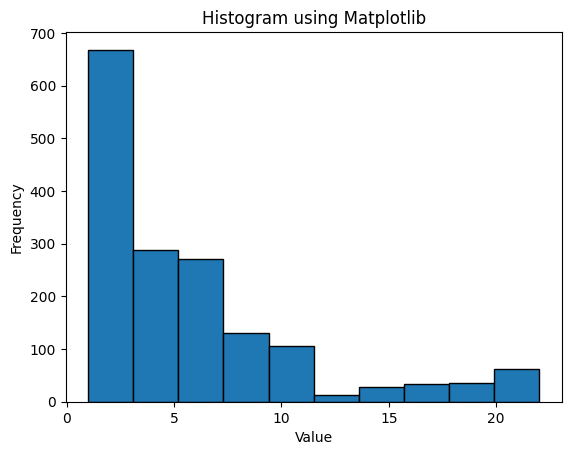

In [23]:
import matplotlib.pyplot as plt

# df_filtered = df[~df['diff_text_len_sum_children_len'].isna()]
# plt.hist(df_filtered['diff_text_len_sum_children_len'], bins=10, edgecolor='black')
# 绘制直方图
plt.hist(df[df['level'] == 'paragraph']['parent_id_num'], bins=10, edgecolor='black')

# plt.hist(df, bins=10, edgecolor='black')


# 添加标题和标签
plt.title('Histogram using Matplotlib')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()

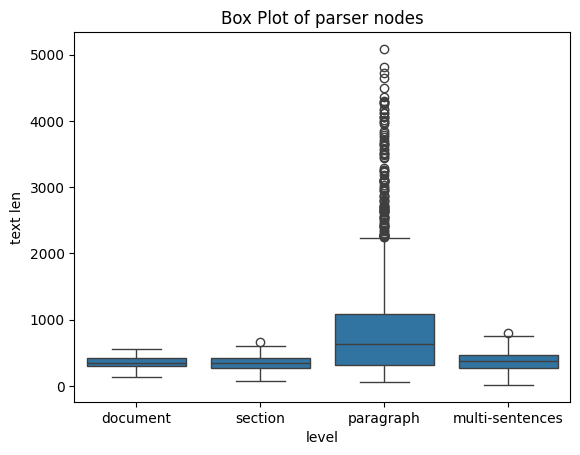

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot
sns.boxplot(x='level', y='text_len', data=df[df['level'] != 'preprocessed_document'])

# Add titles and labels
plt.title('Box Plot of parser nodes')
plt.xlabel('level')
plt.ylabel('text len')

# Show the plot
plt.show()

In [ ]:
df['level'].value_counts()

### Model for sentence classification

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path='D:\Projects(D)\Fine-Tuned-GPT-2-with-articles-ground-truth\code\llamaIndex\.env')
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# load from local
token = os.getenv('GLYCO_TOKEN')
sentence_model = AutoModelForSequenceClassification.from_pretrained("MomochiKyaru/glyco-paper-sentence",token=token)
paragraph_model = AutoModelForSequenceClassification.from_pretrained("MomochiKyaru/glyco-paper-paragraph", token=token)
tokenizer =AutoTokenizer.from_pretrained('MomochiKyaru/glyco-paper-sentence',token=token)

In [ ]:
def get_sentence_prediction(text):
    tokenized_input = tokenizer(text,truncation=True, padding=True, return_tensors='pt')
    logits = sentence_model(**tokenized_input).logits
    probabilities = logits.softmax(dim=1)
    return probabilities.detach().numpy()

In [ ]:
print(df.iloc[0]['abstract'])
print(get_sentence_prediction(df.iloc[0]['abstract']))

### Evaluate

In [ ]:
from datasets import load_dataset

# loading the V2 dataset
amnesty_qa = load_dataset("explodinggradients/amnesty_qa", "english_v2")
amnesty_qa

In [ ]:
from datasets import load_dataset

# loading the V2 dataset
amnesty_qa = load_dataset("explodinggradients/amnesty_qa", "english_v2", trust_remote_code=True)
amnesty_qa

In [ ]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from ragas import evaluate

result = evaluate(
    amnesty_qa["eval"],
    metrics=[
        # context_precision,
        faithfulness,
        # answer_relevancy,
        # context_recall,
    ],
)

result

### LangChain Pydantic

In [18]:
import os
from dotenv import load_dotenv

load_dotenv(os.path.abspath('../.env'))
from langchain_openai import ChatOpenAI
model = ChatOpenAI(temperature=0, api_key=os.getenv('OPENAI_API_KEY'))

In [15]:
import os, sys
sys.path.insert(0, "/run/media/zheng/Elements/Projects(D)/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex")
from custom.schema import LCTemp

In [16]:
parser = LCTemp.parser
prompt = LCTemp.prompt_template

In [5]:
context_str = "Further evidence is emerging from ongoing work in our laboratory that a pathway for the synthesis of sialic acid in plants exists and sialoglycoconjugates can be localized within plant cells (Shah, M. et al.,  unpublished data). The fundamental question to be explored now is not whether plants possess sialic acid but instead, what is the precise metabolic pathway leading to the synthesis of sialic acid in plants and what is its role?"
qar_num = 2

In [7]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"qars": {"title": "Qars", "type": "array", "items": {"$ref": "#/definitions/QAR"}}}, "required": ["qars"], "definitions": {"QAR": {"title": "QAR", "type": "object", "properties": {"Question": {"title": "Question", "description": "The question being asked", "type": "string"}, "Answer": {"title": "Answer", "description": "The answer to the question", "type": "string"}, "Reason": {"title": "Reason", "description": "The reason for the answer", "type": "string"}}, "required": ["Question", "Answer", "Reason"]}}}
```


In [8]:
prompt_str = prompt.format(context_str=context_str, qar_num=qar_num)

In [9]:
print(prompt_str)

You are an expert researcher. Using the following enhanced template, analyze the provided contextual information to generate the top 2 critical academic questions that researchers in this field care about. For each question, provide a thorough and contextually relevant answer, and explain why these questions are significant to researchers and why the provided answers are accurate.

Here is the context:
Further evidence is emerging from ongoing work in our laboratory that a pathway for the synthesis of sialic acid in plants exists and sialoglycoconjugates can be localized within plant cells (Shah, M. et al.,  unpublished data). The fundamental question to be explored now is not whether plants possess sialic acid but instead, what is the precise metabolic pathway leading to the synthesis of sialic acid in plants and what is its role?

Using this context, generate 2 specific questions that this context can uniquely answer. Ensure that these questions:
1. Are directly related to the provid

In [10]:
response = model.invoke(prompt_str)

In [11]:
print(response.content)
result = response.content


{
  "qars": [
    {
      "Question": "What is the precise metabolic pathway leading to the synthesis of sialic acid in plants?",
      "Answer": "The precise metabolic pathway leading to the synthesis of sialic acid in plants is currently being investigated in our laboratory. Initial evidence suggests that a pathway for the synthesis of sialic acid in plants exists.",
      "Reason": "This question is significant to researchers as understanding the metabolic pathway for sialic acid synthesis in plants can provide insights into the unique biochemical processes in plants and potentially lead to the development of novel applications in agriculture and biotechnology."
    },
    {
      "Question": "What is the role of sialic acid in plants?",
      "Answer": "The role of sialic acid in plants is a key question that researchers are aiming to address. Localization of sialoglycoconjugates within plant cells suggests that sialic acid may play important roles in plant physiology.",
      "Re

In [10]:
result = """\
{
  "Question": "What are the precise metabolic pathways leading to the synthesis of sialic acid in plants and what is its role?",
  "Answer": "The precise metabolic pathways leading to the synthesis of sialic acid in plants involve a series of enzymatic reactions that convert precursor molecules into sialic acid. These pathways likely include enzymes such as UDP-N-acetylglucosamine 2-epimerase, N-acetylneuraminate synthase, and CMP-sialic acid synthetase. Sialic acid in plants may play a role in cell-cell recognition, defense mechanisms, or other signaling processes within plant cells.",
  "Reason": "This question is crucial for researchers in the field because understanding the metabolic pathways for sialic acid synthesis in plants can provide insights into the biological significance of sialic acid in plant physiology. By elucidating these pathways and roles, researchers can potentially uncover novel functions of sialic acid in plants and its implications for plant growth, development, and interactions with the environment. The answer provided integrates knowledge from the context and highlights the importance of investigating these specific metabolic pathways and their functional roles in plants." 
}"""

In [12]:
result_obj = parser.parse(result)

In [14]:
result_obj.qars

[QAR(Question='What is the precise metabolic pathway leading to the synthesis of sialic acid in plants?', Answer='The precise metabolic pathway leading to the synthesis of sialic acid in plants is currently being investigated in our laboratory. Initial evidence suggests that a pathway for the synthesis of sialic acid in plants exists.', Reason='This question is significant to researchers as understanding the metabolic pathway for sialic acid synthesis in plants can provide insights into the unique biochemical processes in plants and potentially lead to the development of novel applications in agriculture and biotechnology.'),
 QAR(Question='What is the role of sialic acid in plants?', Answer='The role of sialic acid in plants is a key question that researchers are aiming to address. Localization of sialoglycoconjugates within plant cells suggests that sialic acid may play important roles in plant physiology.', Reason='This question is significant as uncovering the role of sialic acid i

In [15]:
def parse_obj_to_str(objs):
    objs_str = ""
    for obj in objs:
        obj_str = '\n'.join([f'{k}={v}' for k, v in obj.dict().items()])
        objs_str += f"[{obj_str}]\n"
    return objs_str.strip()
parse_obj_to_str(result_obj.qars)

'[Question=What is the precise metabolic pathway leading to the synthesis of sialic acid in plants?\nAnswer=The precise metabolic pathway leading to the synthesis of sialic acid in plants is currently being investigated in our laboratory. Initial evidence suggests that a pathway for the synthesis of sialic acid in plants exists.\nReason=This question is significant to researchers as understanding the metabolic pathway for sialic acid synthesis in plants can provide insights into the unique biochemical processes in plants and potentially lead to the development of novel applications in agriculture and biotechnology.]\n[Question=What is the role of sialic acid in plants?\nAnswer=The role of sialic acid in plants is a key question that researchers are aiming to address. Localization of sialoglycoconjugates within plant cells suggests that sialic acid may play important roles in plant physiology.\nReason=This question is significant as uncovering the role of sialic acid in plants can provi

In [12]:
result_obj.dict()

{'Question': 'What are the precise metabolic pathways leading to the synthesis of sialic acid in plants and what is its role?',
 'Answer': 'The precise metabolic pathways leading to the synthesis of sialic acid in plants involve a series of enzymatic reactions that convert precursor molecules into sialic acid. These pathways likely include enzymes such as UDP-N-acetylglucosamine 2-epimerase, N-acetylneuraminate synthase, and CMP-sialic acid synthetase. Sialic acid in plants may play a role in cell-cell recognition, defense mechanisms, or other signaling processes within plant cells.',
 'Reason': 'This question is crucial for researchers in the field because understanding the metabolic pathways for sialic acid synthesis in plants can provide insights into the biological significance of sialic acid in plant physiology. By elucidating these pathways and roles, researchers can potentially uncover novel functions of sialic acid in plants and its implications for plant growth, development, a

In [ ]:
chain2 = result | parser
result = chain2.invoke()
result

In [ ]:
chain.__dict__

### force_splitter size

In [ ]:
from llama_index.core.node_parser import SentenceSplitter
text = "assessed using comparative thermal analysis. Such interactions are generally revealed in the form of appearance, disappearance, shifting, or changes the melting temperature of ACV. Another minor endothermic event was observed for pure ACV between ~60°C and ~ 175°C (not apparent in the figure). This event may be attributed to the phase transition of polymorphic hydrate form V to anhydrous form III in the range of 65°C and 100°C, and thereafter from form III to anhydrous form VI at higher temperatures. These changes in the thermal characteristics of ACV are not uncommon and have been reported earlier (9, 10, 37). The thermogram of glucosamine HCl (Figure 3B) revealed two, broad, fused endothermic peaks; a larger peak with an onset at ~190°C and a smaller peak in the onset and/or relative areas of the peaks as a function of controlled temperature increases. These interactions may indicate melting, degradation, and/ or incompatibilities between the components of the formulation. The spectra obtained from the infrared analysis of pure ACV, pure glucosamine HCl, the physical mixture (PM, 1:3) of pure ACV and glucosamine HCl, and the prepared ACV-SD are shown in Figure ) revealed two, broad, fused endothermic peaks; a larger peak with an onset at ~190°C and a smaller peak in the onset and/or relative areas of the peaks as a function of controlled temperature increases. These interactions may indicate melting, degradation, and/ or incompatibilities between the components of the formulation. The spectra obtained from the infrared analysis of pure ACV, pure glucosamine HCl, the physical mixture (PM, 1:3) of pure ACV and glucosamine HCl, and the prepared ACV-SD are shown in Figure 4A, 4B, 4C, and 4D, respectively. For pure ACV (Figure , 4B, 4C, and 4D, respectively. For pure ACV (Figure 4A), characteristic absorption bands were located at ~3622 cm-1 (primary amine) and 3411 cm -1 (secondary amine, N-H stretching). Additional peaks typically associated with ACV were found at ~1712 cm -1 (C=O stretching), ~1630 cm -1 and ~1609 cm -1 (amine), ~1483 cm -1 (O-H stretching), and ~1347 cm -1 (C-H stretching). These observations were consistent with previous findings (10, 38). The FTIR spectrum of glucosamine HCl (Figure ), characteristic absorption bands were located at ~3622 cm-1 (primary amine) and 3411 cm -1 (secondary amine, N-H stretching). Additional peaks typically associated with ACV were found at ~1712 cm -1 (C=O stretching), ~1630 cm -1 and ~1609 cm -1 (amine), ~1483 cm -1 (O-H stretching), and ~1347 cm -1 (C-H stretching). These observations were consistent with previous findings (10, 38). The FTIR spectrum of glucosamine HCl (Figure 4B) exhibited a characteristic absorption peak at ~3291 cm -1 (N-H and O-H stretching). Other peaks related to glucosamine were observed at ~3000 cm -1 and 2881 cm -1 (-C-H stretching), ~1618 cm -1 and 1537 cm -1 (N-H bending), ~1140 cm -1 (asymmetric at ~229°C. The first peak is likely associated with the melting of glucosamine HCl, and the second, smaller peak may be associated with its degradation. These results are in agreement with previously published reports ) exhibited a characteristic absorption peak at ~3291 cm -1 (N-H and O-H stretching). Other peaks related to glucosamine were observed at ~3000 cm -1 and 2881 cm -1 (-C-H stretching), ~1618 cm -1 and 1537 cm -1 (N-H bending), ~1140 cm -1 (asymmetric at ~229°C. The first peak is likely associated with the melting of glucosamine HCl, and the second, smaller peak may be associated with its degradation. These results are in agreement with previously published reports (26,27). The thermograms of the physical mixture (Figure . The thermograms of the physical mixture (Figure 3C) exhibited broad, fused peaks similar to that of pure glucosamine HCl, along with the disappearance of the melting peak of ACV."

force_splitter = SentenceSplitter(
    chunk_size=286, 
    chunk_overlap=20, 
    include_metadata=False, 
    include_prev_next_rel=False
)
print(force_splitter._token_size(text))
texts = force_splitter.split_text_metadata_aware(text, "")

In [ ]:
len(texts[0])

### Extractor for response object of batch mode

In [1]:
import os, sys
sys.path.insert(0, "/run/media/zheng/Elements/Projects(D)/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex")
import yaml
from dotenv import load_dotenv
from custom.io import save_nodes_jsonl, load_nodes_jsonl
from custom.extractor import PartalyOpenAIBasedQARExtractor

# Load config
root_path = '../../..'
config_dir_path='./code/llamaIndex/configs'
config_path = os.path.abspath(os.path.join(root_path, config_dir_path, 'config.yaml'))
prefix_config_path = os.path.abspath(os.path.join(root_path, config_dir_path, 'prefix_config.yaml'))
with open(config_path, 'r') as config:
    config = yaml.safe_load(config)
with open(prefix_config_path, 'r') as prefix_config:
    prefix_config = yaml.safe_load(prefix_config)
load_dotenv(dotenv_path=os.path.abspath(os.path.join(root_path, './code/llamaIndex/.env')))

cache_path = os.path.abspath(os.path.join(root_path, config['cache']))
cache_path = '/run/media/zheng/Elements/Projects(D)/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.save'
extractor_config = prefix_config['extractor']['manually_partaly_QAExtractor']

# load extractor
extractor = PartalyOpenAIBasedQARExtractor(
    model_name=extractor_config['llm'],
    cache_dir=os.path.abspath(os.path.join(root_path, config['cache'])),
    mode=extractor_config['mode'],
    embedding_only=extractor_config.get('embedding_only', True)
)

# Load data
input_file = 'gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1.jsonl'
nodes = load_nodes_jsonl(os.path.abspath(os.path.join(cache_path, input_file)))

/home/zheng/miniconda3/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zheng/miniconda3/envs/llm/lib/python3.11/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/zheng/miniconda3/envs/llm/lib/python3.11/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_kwargs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
Loading gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1.jsonl: 100%|██████████| 1.33G/1.33G [00:05<00:00, 243

In [2]:
# Do extracting
output_file_base = 'gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1_extract'
# Extract response to improve the extract presentage
extractor.extract(
    nodes=nodes, 
    cache_path=os.path.abspath(os.path.join(root_path, config['cache'])),
    csv_file_name=output_file_base+'.csv')

Updating nodes: 100%|██████████| 2/2 [00:00<00:00, 448.49nodes/s]

You are an expert researcher. Using the following enhanced template, analyze the provided contextual information to generate the top 2 critical academic questions that researchers in this field care about. For each question, provide a thorough and contextually relevant answer, and explain why these questions are significant to researchers and why the provided answers are accurate.

Here is the context:
Advanced mass spectrometry strategies enable detailed structural analysis and profiling of glycans and glycoconjugates, utilizing techniques like derivatizations, chromatography, electrospray ionization, and matrix-assisted laser desorption/ionization. Electron-based techniques offer promising future developments in this area of study.

Using this context, generate 2 specific questions that this context can uniquely answer. Ensure that these questions:
1. Are directly related to the provided context.
2. Highlight unique information or insights from the context.
3. Cannot be easily answer

In [3]:
import csv

mode = 'batch'

csv_file_name = output_file_base+'.csv'
cache_path = os.path.abspath(os.path.join(root_path, config['cache']))
csv_file = open(os.path.join(cache_path, csv_file_name), 'w', newline='')
# TODO
dataset_writer = csv.DictWriter(csv_file, fieldnames=['node_id', 'qar_num', 'input_text', 'raw_response', 'objs'])
dataset_writer.writeheader()
# target_nodes = nodes[:2] + nodes[-2:]
target_nodes = nodes[:1]
target_nodes[0].metadata['requirements'] = {'qar_num': 1}

if mode == 'immediately':
    for node in tqdm(target_nodes):
        extractor._extract_metadata_from_node_immediately(node)
elif mode == 'batch':
    batches, node_dict, input_file_paths, batch_info_paths = extractor._create_batches_from_nodes(target_nodes)
    uncompleted_batches = {batch.id: batch for batch in batches}
    has_failed, finished_batches = extractor._processing_batches(uncompleted_batches, input_file_paths, batch_info_paths)

    if has_failed:
        exit()

100%|██████████| 1/1 [00:00<00:00, 1473.24it/s], ?batch/s]


Here is the context:
Advanced mass spectrometry strategies enable detailed structural analysis and profiling of glycans and glycoconjugates, utilizing techniques like derivatizations, chromatography, electrospray ionization, and matrix-assisted laser desorption/ionization. Electron-based techniques offer promising future developments in this area of study.

Using this context, generate 1 specific questions that this context can uniquely answer. Ensure that these questions:
1. Are directly related to the provided context.
2. Highlight unique information or insights from the context.
3. Cannot be easily answered by general knowledge.

Higher-level summaries of surrounding context may be provided as well. Try using these summaries to generate better questions that this context can answer.


Here's a JSON schema to follow:
{{"properties": {{"Question": {{"title": "Question", "type": "string"}}, "Answer": {{"title": "Answer", "type": "string"}}, "Reason": {{"title": "Reason", "type": "strin

Processing batches: 100%|██████████| 1/1 [00:14<00:00, 14.21s/batch]


In [7]:
node_dict['a2013402-28e1-4fc7-ae48-3fc81a3fa92a']['node'].metadata

{'level': 'document',
 'title': 'Mass Spectrometry of Glycans',
 'authors': ['Liang Han', 'Catherine E Costello', 'E Catherine'],
 'sections': {'abstract': [37, 642],
  'Introduction': [644, 10803],
  'Glycan release': [10805, 14765],
  'Derivatization of Glycans': [14767, 18048],
  'Separation of glycans': [18050, 23714],
  'Mass spectrometry of glycans': [23716, 45246],
  'Conclusions': [45248, 46621]},
 'file_name': 'Mass_spectrometry_of_glycans.pdf',
 'original_content': 'Title: Mass Spectrometry of Glycans\n\nPowerful new strategies based on mass spectrometry are revolutionizing the structural analysis and profiling of glycans and glycoconjugates. We survey here the major biosynthetic pathways that underlie the biological diversity in glycobiology, with emphasis on glycoproteins, and the approaches that can be used to address the resulting heterogeneity. Included among these are derivatizations, on-and off-line chromatography, electrospray and matrix-assisted laser desorption/ioni

In [4]:
for v, k in finished_batches.items():
    for request in k:
        response = request['response']['body']['choices'][0]['message']['content'].strip()
        print(request)
        print(response)

{'id': 'batch_req_Iw7l0olZAFxl8VfCsBrANoFD', 'custom_id': 'a2013402-28e1-4fc7-ae48-3fc81a3fa92a', 'response': {'status_code': 200, 'request_id': '452dcc84ac33334d4b69cd493985f794', 'body': {'id': 'chatcmpl-A53SJCnxcPVsFr9qAwKZkH0so2XgA', 'object': 'chat.completion', 'created': 1725768287, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '{\n  "Question": "How do electron-based techniques compare to traditional mass spectrometry methods in the structural analysis of glycans and glycoconjugates?",\n  "Answer": "Electron-based techniques, such as electron-capture dissociation (ECD) and electron-transfer dissociation (ETD), offer advanced capabilities for detailed structural analysis of glycans and glycoconjugates. These techniques enable more precise fragmentation patterns and better preservation of labile modifications compared to traditional methods like collision-induced dissociation (CID). This results in more accurate and comprehensiv

### Read qar result from batchoutput

In [1]:
# Load results
import os, sys
sys.path.insert(0, "/run/media/zheng/Elements/Projects(D)/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex")
import json

cache_path = "/run/media/zheng/Elements/Projects(D)/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/"
batchoutput_file_name = "2024-09-08-20-49-36---batchoutput.json"
with open(os.path.join(cache_path, batchoutput_file_name), 'r') as batchout_file:
    batchoutput_results = json.loads(batchout_file.read())

In [2]:
# Load target nodes
from custom.io import load_nodes_jsonl
node_file_name = "target_nodes.jsonl"
nodes = load_nodes_jsonl(os.path.join(cache_path, node_file_name))
node_dict = {}
for node in nodes:
    node_dict[node.id_] = node

from custom.schema import LCTemp
parser = LCTemp.parser
prompt_temp = LCTemp.prompt_template

def parse_obj_to_str(objs):
    if objs is not None:
        return json.dumps([obj.dict() if obj is not None else {} for obj in objs])
    return str([])

Loading target_nodes.jsonl: 100%|██████████| 219M/219M [00:00<00:00, 283MB/s] 


In [4]:
import csv

csv_file_name = "gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1_extract.csv"
csv_file = open(os.path.join(cache_path, csv_file_name), 'w', newline='')

dataset_writer = csv.DictWriter(csv_file, fieldnames=['node_id', 'qar_num', 'input_text', 'raw_response', 'objs'])
dataset_writer.writeheader()
bad_response_num = 0
# Parser results to qar format
for request in batchoutput_results:
    # get response
    response = request['response']['body']['choices'][0]['message']['content'].strip()
    node = node_dict[request['custom_id']]
    try:
        parsed_objs = parser.parse(response)
    except Exception as e:
        print(f"Exception when parse response")
        print(response)
        bad_response_num += 1
        parsed_objs = None
    if parsed_objs is not None:
        parsed_objs = parsed_objs.qars
    objs_str = parse_obj_to_str(parsed_objs)
    # Langchain end
    # write to csv
    output_dict = {}
    requirements = node.metadata['requirements']
    output_dict['node_id'] = node.id_
    output_dict['qar_num'] = requirements['qar_num']
    output_dict['input_text'] = prompt_temp.format(qar_num=requirements['qar_num'], context_str=node.text)
    output_dict['raw_response'] = response
    output_dict['objs'] = objs_str
    dataset_writer.writerow(output_dict)

csv_file.close()

Exception when parse response
{
  "qars": [
    {
      "Question": "What is the significance of isolating Enterobacter ludwigii Ez-185-17 from the Chernobyl area for bioremediation processes?",
      "Answer": "The isolation of Enterobacter ludwigii Ez-185-17 from the Chernobyl area is significant because it suggests that this strain has adapted to survive in a highly radioactive environment, potentially possessing unique genetic and metabolic properties that can be harnessed for bioremediation. Its ability to produce complex exopolysaccharides (EPS) that can bind heavy metals like cadmium (Cd) indicates that it could be used to reduce heavy metal contamination in affected areas.",
      "Reason": "The extreme environment near Chernobyl has likely led to the evolution of microorganisms with unique capabilities. Enterobacter ludwigii Ez-185-17's EPS properties provide a dual function: allowing the bacteria to survive in harsh conditions and offering a mechanism to capture and immobiliz

In [5]:
bad_response_num

15

In [14]:
# Load nodes
from custom.io import load_nodes_jsonl
node_file_name = "gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1.jsonl"
nodes = load_nodes_jsonl(os.path.join(cache_path, node_file_name))
node_dict = {}
for node in nodes:
    node_dict[node.id_] = node

Loading gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1.jsonl: 100%|██████████| 1.33G/1.33G [00:06<00:00, 230MB/s] 


In [15]:
len(nodes)

45834

### Visualize extract result

In [6]:
import os
import pandas as pd
cache_path = '/run/media/zheng/Elements/Projects(D)/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache'
csv_file_name = "gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1_extract.csv"
df = pd.read_csv(os.path.join(cache_path, csv_file_name))

In [7]:
df

,node_id,qar_num,input_text,raw_response,objs
0,a2013402-28e1-4fc7-ae48-3fc81a3fa92a,3,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""How ...","[{""Question"": ""How do advanced mass spectromet..."
1,1afa3420-36ca-44e3-9c70-96779dce6c91,3,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""What...","[{""Question"": ""What specific mechanism allows ..."
2,37e78ddb-6196-49c4-b786-ddec2ff70c7e,3,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""How ...","[{""Question"": ""How does the administration of ..."
3,56eabac7-8098-4427-8836-ac323e92d31b,3,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""What...","[{""Question"": ""What is the significance of sma..."
4,1422854f-c275-4872-a4df-1d2eb73691e3,3,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""How ...","[{""Question"": ""How do glycosylation patterns o..."
...,...,...,...,...,...
3495,4b89f337-24cb-4e93-860c-f9ab8e008f9f,1,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""What...","[{""Question"": ""What specific factors could acc..."
3496,0fb2ebad-7c51-4a28-b15b-963a0fe333f0,1,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""How ...","[{""Question"": ""How can the recent discovery of..."
3497,4e8e9c31-9b81-4b36-8f50-cb64b2f3965e,1,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""What...","[{""Question"": ""What are the advantages and lim..."
3498,d108e671-f55a-411d-a31a-aa81340ca007,1,You are an expert researcher. Using the follow...,"{\n ""qars"": [\n {\n ""Question"": ""How ...","[{""Question"": ""How does the high level of 4-ga..."


In [13]:
import json
invalid_count = 0
for row_id in range(len(df)):
    obj_json = json.loads(df['objs'][row_id])
    if df['qar_num'][row_id] != len(obj_json):
        print(row_id, df['qar_num'][row_id], len(obj_json))
        invalid_count += 1
invalid_count

174 3 0
567 1 0
1147 1 0
1174 1 0
1312 1 0
1326 1 0
1594 1 0
1809 1 0
2098 1 0
2135 1 0
2240 1 0
2590 1 0
2836 1 0
2941 1 0
3050 1 0


15

### re Format response

In [1]:
import os, sys
sys.path.insert(0, "/run/media/zheng/Elements/Projects(D)/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex")
from custom.schema import LCTemp

parser = LCTemp.parser
prompt = LCTemp.prompt_template

def parse_obj_to_str(objs):
    objs_str = ""
    for obj in objs:
        obj_str = '\n'.join([f'{k}={v}' for k, v in obj.dict().items()])
        objs_str += f"[{obj_str}]\n"
    return objs_str.strip()

In [2]:
response = "{\n  \"qars\": [\n    {\n      \"Question\": \"What are the potential pharmacological benefits of the compounds isolated from the leaves and flowers of T. procumbens?\",\n      \"Answer\": \"The compounds isolated from T. procumbens, including dexamethasone luteolin, glucoluteolin, \u03b2-sitosterol quercetin, \u03b2-sitosterol-3-o-\u03b2-D-xylopyranoside, and flavonoid procumbenetin, possess a range of pharmacological properties. Dexamethasone luteolin and glucoluteolin have anti-inflammatory and antioxidant activities, \u03b2-sitosterol quercetin exhibits anti-cancer and anti-inflammatory properties, and \u03b2-sitosterol-3-o-\u03b2-D-xylopyranoside and flavonoid procumbenetin are noted for their potential in modulating immune response and exhibiting antimicrobial activities. Moreover, novel water-soluble polysaccharides from T. procumbens may offer unique therapeutic potentials such as immune system modulation and antiviral effects.\",\n      \"Reason\": \"This question is significant to researchers because understanding the pharmacological benefits of natural compounds helps in the development of new therapeutic agents. The accurate answer leverages the specific information provided about the identified compounds and their sources (leaves and flowers of T. procumbens), as well as their known pharmacological effects reported in previous studies. This contextual analysis could guide further research on the medicinal use of T. procumbens and its isolated compounds.\"\n    }\n  ]\n}"
parser.parse(response)

here 1
parser: {'qars': [{'Question': 'What are the potential pharmacological benefits of the compounds isolated from the leaves and flowers of T. procumbens?', 'Answer': 'The compounds isolated from T. procumbens, including dexamethasone luteolin, glucoluteolin, β-sitosterol quercetin, β-sitosterol-3-o-β-D-xylopyranoside, and flavonoid procumbenetin, possess a range of pharmacological properties. Dexamethasone luteolin and glucoluteolin have anti-inflammatory and antioxidant activities, β-sitosterol quercetin exhibits anti-cancer and anti-inflammatory properties, and β-sitosterol-3-o-β-D-xylopyranoside and flavonoid procumbenetin are noted for their potential in modulating immune response and exhibiting antimicrobial activities. Moreover, novel water-soluble polysaccharides from T. procumbens may offer unique therapeutic potentials such as immune system modulation and antiviral effects.', 'Reason': 'This question is significant to researchers because understanding the pharmacological 

MultipleQARs(qars=[QAR(Question='What are the potential pharmacological benefits of the compounds isolated from the leaves and flowers of T. procumbens?', Answer='The compounds isolated from T. procumbens, including dexamethasone luteolin, glucoluteolin, β-sitosterol quercetin, β-sitosterol-3-o-β-D-xylopyranoside, and flavonoid procumbenetin, possess a range of pharmacological properties. Dexamethasone luteolin and glucoluteolin have anti-inflammatory and antioxidant activities, β-sitosterol quercetin exhibits anti-cancer and anti-inflammatory properties, and β-sitosterol-3-o-β-D-xylopyranoside and flavonoid procumbenetin are noted for their potential in modulating immune response and exhibiting antimicrobial activities. Moreover, novel water-soluble polysaccharides from T. procumbens may offer unique therapeutic potentials such as immune system modulation and antiviral effects.', Reason='This question is significant to researchers because understanding the pharmacological benefits of 

In [26]:
def parse_obj_to_str(objs):
    if objs is not None:
        return json.dumps([obj.dict() if obj is not None else {} for obj in objs])
    return str([])

'[]'

In [36]:
response = "{\n  \"qars\": [\n  \"  {\n   \'   \'Question\": \"How does maintaining healthy blood sugar levels impact mental health?\",\n      \"Answer\": \"Maintaining healthy blood sugar levels helps to stabilize mood, reduces the risk of depression and anxiety, and improves cognitive function.\",\n      \"Reason\": \"Fluctuations in blood sugar levels can lead to irritability, mood swings, and cognitive impairment. Consistent blood sugar management supports brain health and emotional stability, which are critical for mental well-being.\"\n    },\n    {\n      \"Question\": \"What role do healthy blood sugar levels play in physical health and recovery from illnesses?\",\n      \"Answer\": \"Healthy blood sugar levels are integral for maintaining energy levels, supporting immune function, and speeding up the recovery process from illnesses.\",\n      \"Reason\": \"Stable blood sugar levels ensure a steady supply of glucose to cells for energy and repair. This helps in reducing inflammation and boosting the body's ability to heal, thus improving overall recovery time.\"\n    },\n    {\n      \"Question\": \"What mechanisms link blood sugar levels to both physical and mental health?\",\n      \"Answer\": \"Blood sugar levels influence physical and mental health through mechanisms involving insulin regulation, oxidative stress, and inflammation.\"\n      \"Reason\": \"Insulin regulation plays a crucial part in converting blood sugar into energy, while oxidative stress and inflammation caused by imbalanced blood sugar levels can damage cells and tissues, affecting both body and brain health.\"]\n    }\n  ]\n}"
print(response)

{
  "qars": [
  "  {
   '   'Question": "How does maintaining healthy blood sugar levels impact mental health?",
      "Answer": "Maintaining healthy blood sugar levels helps to stabilize mood, reduces the risk of depression and anxiety, and improves cognitive function.",
      "Reason": "Fluctuations in blood sugar levels can lead to irritability, mood swings, and cognitive impairment. Consistent blood sugar management supports brain health and emotional stability, which are critical for mental well-being."
    },
    {
      "Question": "What role do healthy blood sugar levels play in physical health and recovery from illnesses?",
      "Answer": "Healthy blood sugar levels are integral for maintaining energy levels, supporting immune function, and speeding up the recovery process from illnesses.",
      "Reason": "Stable blood sugar levels ensure a steady supply of glucose to cells for energy and repair. This helps in reducing inflammation and boosting the body's ability to heal, th

In [39]:
import re

response = re.sub(r"(?<!\w)'|'(?!\w)", '"', response)
print(response)

# Step 1: Remove the single quotes and dould qoutes when without /w
response = re.sub(r"(?<!\w)\"(?!\w)", '', response)
print(response)

{
  "qars": [
    {
      "Question": "How does maintaining healthy blood sugar levels impact mental health?,
      "Answer": "Maintaining healthy blood sugar levels helps to stabilize mood, reduces the risk of depression and anxiety, and improves cognitive function.,
      "Reason": "Fluctuations in blood sugar levels can lead to irritability, mood swings, and cognitive impairment. Consistent blood sugar management supports brain health and emotional stability, which are critical for mental well-being.
    },
    {
      "Question": "What role do healthy blood sugar levels play in physical health and recovery from illnesses?,
      "Answer": "Healthy blood sugar levels are integral for maintaining energy levels, supporting immune function, and speeding up the recovery process from illnesses.,
      "Reason": "Stable blood sugar levels ensure a steady supply of glucose to cells for energy and repair. This helps in reducing inflammation and boosting the body's ability to heal, thus impr

In [34]:
# Step 2: Add missing commas between JSON objects or list items
# response = re.sub(r'("\s*[\]}])(\s*[{["])', r'\1,\2', response)
response = re.findall(r'"(\w)"', response, re.DOTALL)
print(response)

[]


In [ ]:
pattern = r'\{(.*?)\}'
matches = re.findall(pattern, response, re.DOTALL)
print(matches)

# parser.parse(response)
# print(response)
# print(cleaned_text)
# # import json
# json.loads(cleaned_text)

### Test parser code robustness

In [1]:
# init step
import yaml

cache_path = "/workspace/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache"
input_file_name = "gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_processing.jsonl"
pid = 0
node_number_per_process = 50

prefix_config_path = '/workspace/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/configs/prefix_config.yaml'
prefix_config_file = open(prefix_config_path, 'r')
prefix_config = yaml.safe_load(prefix_config_file)
llm_config = prefix_config['llm']['lmsys/vicuna-13b-v1.5']
embedding_config = prefix_config['embedding_model']['Linq-AI-Research/Linq-Embed-Mistral']

In [2]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))
from custom.io import load_nodes_jsonl

# Load nodes
nodes_cache_path = os.path.abspath(os.path.join(cache_path, input_file_name))
nodes = load_nodes_jsonl(nodes_cache_path)[pid*node_number_per_process: (pid+1)*node_number_per_process]

Loading gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_processing.jsonl: 100%|██████████| 439M/439M [00:01<00:00, 295MB/s] 


In [3]:
from custom.parser import CustomHierarchicalNodeParser

# Load parser
parser = CustomHierarchicalNodeParser.from_defaults(
    llm_self=None,
    llm_config=llm_config,
    embedding_config=embedding_config,
    cache_dir_path='/workspace/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache',
    cache_file_name=f'pid-{pid}.jsonl'
)

/root/miniconda3/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/llm/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in CustomHuggingFaceLLM has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/root/miniconda3/envs/llm/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in CustomHuggingFaceLLM has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [19]:
parser._level2nodes = {level:[] for level in parser._chunk_levels + ['preprocessed_document']}

In [20]:
print(parser._level2nodes)

None


In [13]:
import json
from tqdm import tqdm
from llama_index.core.schema import TextNode

# Load the cache file
file_size = os.path.getsize(parser._cache_process_path)
with open(parser._cache_process_path, 'r') as cache_file:
    with tqdm(total=file_size, desc='Loading cache...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
        for line in cache_file:
            node_dict = json.loads(line)
            node = TextNode.from_dict(node_dict)
            print(node.metadata['level'])
            parser._level2nodes[node.metadata['level']].append(node)
            # Update progress bar based on bytes read
            pbar.update(len(line))

Loading cache...:   0%|          | 0.00/112M [00:00<?, ?B/s]

preprocessed_document


TypeError: 'NoneType' object is not subscriptable

In [6]:
# nodes = parser.get_nodes_from_documents(nodes, show_progress=True)
non_finished_documents = parser._init_get_nodes_from_documents(nodes)
# input(len(non_finished_documents))


{'document': [], 'section': [], 'paragraph': [], 'multi-sentences': [], 'preprocessed_document': []}


Loading cache...: 100%|██████████| 112M/112M [00:00<00:00, 184MB/s] 


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like lmsys/vicuna-13b-v1.5 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:

if show_progress:
    with tqdm(total=len(documents), desc="parsing documents") as pbar:
        pbar.update(len(documents) - len(non_finished_documents))
        for document in non_finished_documents:
            self._get_nodes_from_one_document(document, pbar)
else:
    for document in non_finished_documents:
        self._get_nodes_from_one_document(document)
self._cache_process_file.close()